In [1]:
import pyphen
import string
import re
import collections

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Flatten
import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
hypher = pyphen.Pyphen(lang='hu_HU')

In [3]:
def hyph_tags(word, hypher=pyphen.Pyphen(lang='hu_HU'), aslist=False):
    """Hyphenating classification of the characters in the word. {B(egin),M(iddle),E(nd),S(ingle)}"""
    if(len(word)==0):
        raise IndexError("0 length word")
    ret = list('M' * len(word))
    ret[0]='B'
    ret[-1]='E'
    for i in hypher.positions(word):
        ret[i]='B'
        if(ret[i-1]=='B'):
            ret[i-1]='S'
        else:
            ret[i-1]='E'
    if(aslist):
        return ret
    return "".join(ret)

def hyph_tags_4to2(word, aslist=False):
    """{B,M,E,S} to {B, M}"""
    ret = list(word)
    for i in range(len(ret)):
        if ret[i]=='S':
            ret[i]='B'       
        if ret[i]!='B':
            ret[i]='M'
    if(aslist):
        return ret
    return "".join(ret)   

def same_char_num(word, hypher=pyphen.Pyphen(lang='hu_HU')):
    """Return true if the hyphenated word has as many chars as the original"""
    return len(hypher.inserted(word))==len(word)+len(hypher.positions(word))

def cleaning(data):
    """Text cleaning:
        lower the letters
        punctuation, digits ellimination"""
    formated_data = data.lower()
    formated_data = re.sub('['+string.punctuation+']','',formated_data)
    formated_data = re.sub('['+string.digits+']','',formated_data)
    return formated_data

# Data import

In [129]:
counter_hu_data = collections.Counter()
word_list = []
c_all = 0
c_same_char_num = 0
with open('web2.2-freq-sorted.txt','r',errors='ignore',encoding='latin2') as f:
    i = 0
    for line in f:
        i = i+1
        words = line.split()
        if len(words)>1:
            if(words[1].isdigit()):
                counter_hu_data[cleaning(words[0])]+=int(words[1])
        if i>100000:
            break
for words in counter_hu_data.most_common():
    c_all+=1
    next_word = words[0]
    if(len(next_word)!=0 and same_char_num(next_word)):
        c_same_char_num+=1
        #print(next_word, hyph_tags(next_word), hyph_tags_4to2(hyph_tags(next_word)))
        word_list.append([next_word,hyph_tags_4to2(hyph_tags(next_word))])

In [130]:
print(c_same_char_num,c_all,c_same_char_num/c_all)

82181 83286 0.9867324640395745


In [131]:
print(word_list[100:200])

[['ember', 'BMBMM'], ['ezek', 'BMMM'], ['tovább', 'BMBMMM'], ['vagyok', 'BMBMMM'], ['ma', 'BM'], ['miatt', 'BMBMM'], ['this', 'BMMM'], ['mellett', 'BMMBMMM'], ['vannak', 'BMMBMM'], ['by', 'BM'], ['alapján', 'BMMMBMM'], ['lenne', 'BMMBM'], ['with', 'BMMM'], ['that', 'BMMM'], ['tehát', 'BMBMM'], ['te', 'BM'], ['it', 'BM'], ['ben', 'BMM'], ['egész', 'BMMMM'], ['néhány', 'BMBMMM'], ['milyen', 'BMBMMM'], ['át', 'BM'], ['nekem', 'BMBMM'], ['előtt', 'BMMMM'], ['ezzel', 'BMBMM'], ['mivel', 'BMBMM'], ['ezen', 'BMMM'], ['nélkül', 'BMMBMM'], ['lett', 'BMMM'], ['stb', 'BMM'], ['you', 'BMM'], ['viszont', 'BMBMMMM'], ['év', 'BM'], ['teljes', 'BMMBMM'], ['erre', 'BMBM'], ['hiszen', 'BMBMMM'], ['másik', 'BMBMM'], ['ebben', 'BMBMM'], ['mind', 'BMMM'], ['der', 'BMM'], ['három', 'BMBMM'], ['talán', 'BMBMM'], ['valami', 'BMBMBM'], ['die', 'BMM'], ['bár', 'BMM'], ['are', 'BMM'], ['legyen', 'BMBMMM'], ['tudom', 'BMBMM'], ['from', 'BMMM'], ['inkább', 'BMBMMM'], ['során', 'BMBMM'], ['például', 'BMMBMBM'], ['r

# Data preparation

In [7]:
#onehot: {'B','M','E','S'}
def one_hot_encode(char,dictionary='BMES'):
    ret = [0]*len(dictionary)
    if char in dictionary:
        ret[dictionary.find(char)]=1
        return ret
    raise ValueError('Value out of dictionary range'+char)
def unison_shuffled_copies(a, b):
    """Randomize 2 same length array in the same permutation"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
def one_hot_decode(arr,dictionary='BMES'):
    assert len(arr)==len(dictionary)
    i = np.nonzero(arr)[0][0]
    return dictionary[i]

In [38]:
hun_chars='aábcdeéfghiíjklmnoóöőpqrstuúüűvwxyz'+'^$' # ^,$
def generate_network_data(data, ret_input = [],ret_output=[],length = 2, length_after=0, start_char='^', end_char='$', chars=hun_chars, tag_chars='BMES'):
    """from [word,hyph_class(word) to length-long input-output data"""
    word = data[0]
    word_plus = start_char*(length-length_after-1)+word+end_char*length_after
    hyph_word = data[1]
    for i in range(0,len(word)):
        input_next_iter = []
        for c in word_plus[i:i+length]:
            input_next_iter.append(one_hot_encode(c,chars))
        output_next_iter = one_hot_encode(hyph_word[i],tag_chars)
        ret_input.append(input_next_iter)
        ret_output.append(output_next_iter)

In [78]:
wc_in=[]
wc_out=[]

generate_network_data(['alma','BEBE'],wc_in, wc_out,3,1)
print(wc_in[0],wc_out[0])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] [1, 0, 0, 0]


In [132]:
window_length = 5
length_after = 2
tag_chars='BM'

In [133]:
data_in = []
data_out = []
wrong_word = 0
for word in word_list:
    try:
        generate_network_data(word,data_in,data_out,window_length, tag_chars=tag_chars, length_after=length_after)
    except ValueError:
        wrong_word+=1
print('Data len: ',len(data_in))
print('Wrong words: ',wrong_word)

Data len:  695071
Wrong words:  640


In [134]:
valid_rate=0.2
test_rate=0.1
data_len = len(data_in)
data_in = np.array(data_in,dtype='float32')
data_out = np.array(data_out,dtype='float32')
data_in, data_out = unison_shuffled_copies(data_in,data_out)
tests_input = data_in[0:int (data_len*test_rate)]
tests_target= data_out[0:int(data_len*test_rate)]
valid_input = data_in[int (data_len*test_rate) : int (data_len*(test_rate+valid_rate))]
valid_target= data_out[int(data_len*test_rate): int (data_len*(test_rate+valid_rate))]
train_input = data_in[int (data_len*(test_rate+valid_rate)):]
train_target= data_out[int(data_len*(test_rate+valid_rate)):]


print('Training data size:',np.shape(train_input), np.shape(train_target))
print('Validation data size:',np.shape(valid_input), np.shape(valid_target))
print('Test data size:',np.shape(tests_input), np.shape(tests_target))

Training data size: (486550, 5, 37) (486550, 2)
Validation data size: (139014, 5, 37) (139014, 2)
Test data size: (69507, 5, 37) (69507, 2)


In [135]:
train_input_flatten = np.reshape(train_input,(len(train_input),(window_length)*len(hun_chars)))
valid_input_flatten = np.reshape(valid_input,(len(valid_input),(window_length)*len(hun_chars)))

# DNN Model

In [147]:
model = Sequential()
model.add(Dense(input_dim=((window_length)*len(hun_chars)), 
                units=10, name='input_layer',activation='sigmoid'))
model.add(Dense(units=10, activation='sigmoid'))

#model.add(Flatten())
model.add(Dense(2,name='output_layer', activation='softmax'))

In [148]:
train_input_flatten.shape

(486550, 185)

In [149]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')

In [150]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [151]:
history = model.fit(train_input_flatten,train_target, epochs=1000, batch_size=1024,
                    validation_data=(valid_input_flatten,valid_target), verbose=0,
                   shuffle= True, callbacks=[earlyStopping])

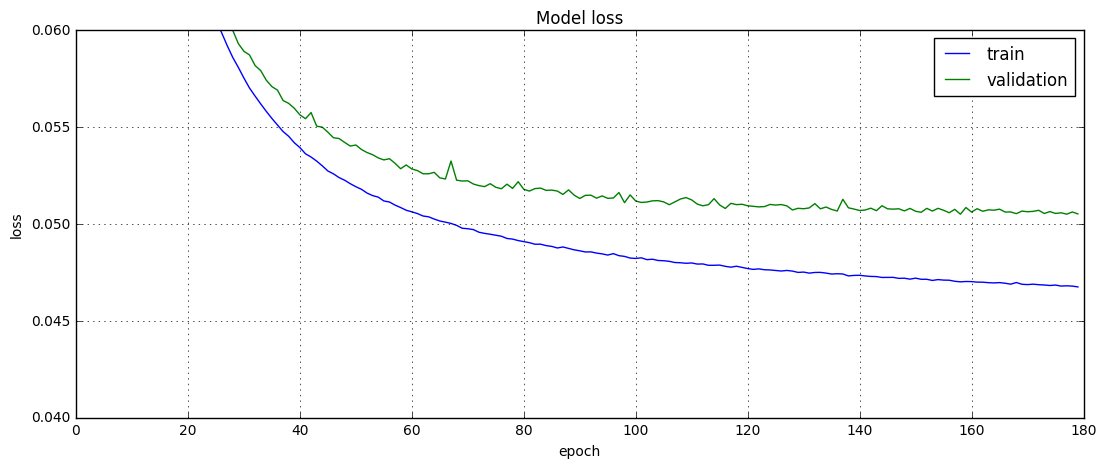

In [152]:
# summarize history for loss
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.ylim((0.04,0.06))
plt.grid()
plt.show()

In [153]:
print(history.history['val_loss'][-10:],history.epoch[-1])

[0.050619446564624027, 0.050638899225444969, 0.05069314670939716, 0.050529311734467015, 0.050628988604456616, 0.050532041988777116, 0.050565773248843995, 0.050493857314084227, 0.050608123122131379, 0.050508843151763815] 179


In [109]:
def hpyh_predict(word, model, length = 2, length_after = 0, tag_chars = 'BMES', aslist = False):
    word_in =[]
    word_out = []
    generate_network_data([word,len(word)*tag_chars[0]],word_in,word_out, length=length, length_after=length_after, tag_chars=tag_chars)
    word_in = np.reshape(word_in,(len(word_in),(length)*len(hun_chars)))
    word_out = model.predict(word_in)
    tag_list = np.array(list(tag_chars))
    temp = np.argmax(word_out, axis=1)
    temp = tag_list[temp]
    if(aslist):
        return temp
    return "".join(temp)  

In [128]:
test = 'szemüveg'
print('Word:',test,'Prediction:',hpyh_predict(test,model,window_length,length_after,tag_chars),
      'Target:',hyph_tags(test))
test = 'leopárd'
print('Word:',test,'Prediction:',hpyh_predict(test,model,window_length,length_after,tag_chars),
      'Target:',hyph_tags(test))

Word: szemüveg Prediction: BMEEEBME Target: BMMEBMME
Word: leopárd Prediction: BESEMME Target: BESBMME
